Модель нейронной сети, которая позволяет проводить распознование рукописных цифр. 

Модель выполнена по книге *Тарик Рашид - Создаем нейронную сеть* (https://www.ozon.ru/context/detail/id/141796497/)


# Обучение нейронной сети.

## Описание основных формул и идей.

Допустим у нас трехслойная нейронная сеть, с тремя слоями:
$$
    input \rightarrow hidden \rightarrow output
$$

В процессе обучения выделяют следующие шаги (тут $W$ - это **матрица** весов):

1. Прямой проход (суммирование всех взвешенных input-ов). Получаем промежуточный output.
    - Выход hidden слоя: $O_{hid} = W_{inp, hid} \times I_{inp}$
    - Выход output слоя (одновременно и выход сети): $O_{out} = W_{hid, out} \times I_{hid}$

```pyhton
    hidden_input = np.dot(self.wih, inputs)
```


2. Применяем функцию активации к каждому из промежуточных output-ов.
    - Выход hidden слоя: $O_{hid} = sigm(W_{inp, hid} \times I_{inp})$
    - Выход output слоя: $O_{out} = sigm(W_{hid, out} \times I_{hid})$

```pyhton
    hidden_output = self.act_func(hidden_input)
```

**Промежуточный итог**: завершился прямой проход нейронной сети. Как результат на выходном слое у нас есть итоговые предсказания.

3. Вычисление ошибки предсказания для output слоя (используем квадратичную ошибку).
    - Величинаа ошибки: $E_{out} = (expect_{out} - O_{out})^{2}$

```pyhton
    out_errors = targets - out_output
```

4. Обратное распростронение ошибки (вычисление ошибки для hidden слоя, и других если бы они были).
    - Величина ошибки: $E_{hid} = W_{hid, out}^{T} \times E{out}$

```pyhton
    hidden_errors = np.dot(self.who.T, out_errors)
```

**Промежуточный итог**: тут показано как вычислять ошибку предсказания для output слоя и всех предыдущих при движении в обратном направлении, то есть от $output \rightarrow input$.

P.S. Oшибка каждого нейрона делится между нейронами которые сформировали выход данного нейрона, пропорционально весам связи. 
Мы просто не нормируем на сумму всех весов по столбцу, так как это не особо важно.

5. Обновление весовых коэффициентов (главное в нейронной сети).
    - Весовые коэффициенты hidden/output слоев: 
    $W_{hid, out} = W_{hid, out} - \alpha \partial E_{out}/\partial W_{hid, out}$
    - Весовые коэффициент input/hidden слоев: 
    $W_{inp, hid} = W_{inp, hid} - \alpha \partial E_{hid}/\partial W_{inp, hid}$

```pyhton
    self.who += self.lr * np.dot( (out_errors * out_output * (1.0 - out_output)), np.transpose(hidden_output) )
```

**Окончательный итог**: мы научились обновлять весовые коэффициенты нейронной сети используя градиентный спуск.

## Краткое описание алгоритма обучения.

Таким образом, мы выполняем следующую последовтельность действий:
1. Прямой проход от последовательно от input слоя до output слоя(см. выше пункты 1 и 2). В итоге у нас есть предсказание нейронной сети.
2. Вычисление ошибки предсказания для output слоя (см. пункт 3.)
3. Вычислить ошибку на предыдущем для output слоя (см. пункт 4.)
4. Модифицировать весовые коэффициенты между output слоем и предыдущим (см. пункт 5.)
5. Повторять пункты (3-4) до тех пор, пока не дойдем до input слоя (таким образом мы обновим все веса сети).

## Пример расчета градиента функции.

Допустим при обучении используется квадратичная функция ошибки: $E_{out} = (expected - output)^{2}$.

Рассмотрим как будет выглядеть выражение для обновление весов (пункт 5) в данном виде:
$$
    w_{hid, out} = w_{hid, out} - \alpha \frac{\partial E_{out}}{\partial W_{hid, out}}.
$$

Рассмотрим подробнее частную производную от ошибки:
$$
    \frac{\partial E_{out}}{\partial w_{hid, out}} = 
    \frac{\partial E_{out}}{\partial O_{out}} \times \frac{\partial O_{out}}{w_{hid,out}} \qquad (1)
$$

Допустим, мы имеем дело с квадратичной ошибкой: $E_{out}=(T_{out}-O_{out})^{2}$, где $T_{out}$ - это target.

В таком случае первый член выражения (1):

$$
    \frac{\partial E_{out}}{\partial O_{out}} = -2 \times (T_{out}-O_{out})
$$

Так же предположим, что функция активации - сигмиоида ($sigm(x)$), тогда поскольку $sigm(x)'=sigm(x)\times (1-sigm(x))$, то второй множитель выражения (2):
$$
    \frac{\partial O_{out}}{\partial W_{hid, out}} = 
    sigm \Big(\sum_{hid}w_{hid, out}O_{hid}\Big) \times \Big(1 - sigm \Big(\sum_{hid}w_{hid, out}O_{hid}\Big)\Big) \times O_{hid}
$$

Таким образом окончательный вид градиента:
$$
    \frac{\partial E_{out}}{\partial W_{hid, out}} = 
    -2 \times (T_{out}-O_{out}) \times
    sigm \Big(\sum_{hid}w_{hid, out}O_{hid}\Big) \times \Big(1 - sigm \Big(\sum_{hid}w_{hid, out}O_{hid}\Big)\Big) \times O_{hid}
$$


In [1]:
import os
import time
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

# Нейронная сеть (3 слоя)

In [2]:
class neuralNetwork:
    
    def __init__(self, 
                 input_noes, 
                 hidden_nodes, 
                 out_nodes, 
                 learning_rate, 
                 activation_function = lambda x: scipy.special.expit(x)
                ):
        self.inodes = input_noes
        self.hnodes = hidden_nodes
        self.onodes = out_nodes
        
        self.lr = learning_rate
        
        # Задаются как выборка из нормального распределения с центром в нуле, и мат. ожиданием равным
        # 1. / (корень квадратный из количества узлов)
        # Weights between input and hidden layers
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        # Weights between hidden and output layers
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # Activation function
        self.act_func = activation_function
    
    # NW train function
    def train(self, input_list, target_list):
        inputs = np.array(input_list, ndmin = 2).T
        targets = np.array(target_list, ndmin = 2).T
        
        # Caluclate output of hidden layer
        hidden_input = np.dot(self.wih, inputs)
        hidden_output = self.act_func(hidden_input)
        
        # Calculate output of output layers
        out_input = np.dot(self.who, hidden_output)
        out_output = self.act_func(out_input)
        
        # Calculate error of output layer
        out_errors = targets - out_output
        
        # Reverse error correction on output->hidden layer
        hidden_errors = np.dot(self.who.T, out_errors)
        self.who += self.lr * np.dot( (out_errors * out_output * (1.0 - out_output)), np.transpose(hidden_output) )
        
        # Reverse error correction on hidden->input layer
        self.wih += self.lr * np.dot( (hidden_errors * hidden_output * (1.0 - hidden_output)), np.transpose(inputs) )
        
    
    # Calculate output results based on choosen 'input_list' data
    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin = 2).T
        
        hidden_input = np.dot(self.wih, inputs)
        hidden_output = self.act_func(hidden_input)
        
        out_input = np.dot(self.who, hidden_output)
        out_output = self.act_func(out_input)
        
        return out_output

### Обучение сети

In [131]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10

learning_rate = 0.2

# Number of repetition for NW on single dataset
epoch_number = 5

train_file_path = os.path.join(os.getcwd(), 'mnist_dataset', 'mnist_train.csv')

if __name__ == '__main__':
    nw = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
    
    # Prepare trainig data
    trainig_data_file = open(train_file_path, 'r')
    train_data_list = trainig_data_file.readlines()
    trainig_data_file.close()
    
    for i in range(epoch_number):
        for record in train_data_list:
            all_values = record.split(',')
            # Create data for input nodes
            # Convert from [0,255] range to [0.01, 1.0]
            input_data = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

            # Create output targets
            # If output is 5 -> [0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01,]
            output_data = np.zeros(output_nodes) + 0.01
            output_data[int(all_values[0])] = 0.99

            nw.train(input_data, output_data)

### Кросс-валидация сети

In [132]:
test_file_path = os.path.join(os.getcwd(), 'mnist_dataset', 'mnist_test.csv')

test_data_file = open(test_file_path, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

scores = []

if __name__ == '__main__':
    
    for record in test_data_list:
        test_values = record.split(',')
        test_input = (np.asfarray(test_values[1:]) / 255.0 * 0.99) + 0.01
        expected_value = int(test_values[0])
        
        train_values = nw.query(test_input)
        
        if expected_value == np.argmax(train_values):
            scores.append(1)
        else:
            scores.append(0)
    
    scores = np.asarray(scores)
    print('NW efficiency: {0}'.format(float(np.sum(scores)) / float(scores.size)))
    

NW efficiency: 0.962


## Нейронная сеть, которая рисует цифры


Параметры нейронной сети.

In [3]:
input_nodes = 10
hidden_nodes = 100
output_nodes = 784

learning_rate = 0.1
activation_function = lambda x: scipy.special.expit(x)

epoch_numb = 5

### Необходимые функции

In [4]:
def read_data(path):
    '''
        Read incoming MNIST dataset
    '''
    if not os.path.exists(path):
        raise Exception('Path: {0} does not exists'.format(path))
    
    with open(path) as f:
        return f.readlines()

def display_number(data):
    '''
        Displays number as a picture.
    '''
    if data.shape[0] != 784:
        raise Exception('Wrong input data.')
    plt.imshow(data.reshape(28, 28), cmap='Greys', interpolation='None')
    plt.show()

def normalize(data):
    '''
        Normalize the output data.
    '''
    if data.shape[0] != 784:
        raise Exception('Wrong input data.')
    return data / 255.0 * 0.99 + 0.01

def train_all(nw, input_data, epoch_numb=1):
    '''
        Train NN on all incoming data
    '''
    for i in range(epoch_numb):
        # Train on incoming set of data
        for line in input_data:
            data = line.split(',')
            # Prepare input for NN 
            input_list = np.zeros(10) + 0.01
            input_list[int(data[0])] = 0.99
            # Prepare target for NN
            target_list = normalize(np.asfarray(data[1:]))
            nw.train(input_list, target_list)

### Обучение нейронной сети

In [5]:
# Path to dataset
file_path = os.path.join(os.getcwd(), 'mnist_dataset', 'mnist_train.csv')

nw = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, activation_function)

try:
    input_data = read_data(file_path)
    start = time.time()
    train_all(nw, input_data, epoch_numb)
    print('Train time: {0}'.format(time.time() - start))
except Exception as e:
    print('Error: ', str(e))

Train time: 285.4944634437561


### Тестирование нейронной сети

Number =  0


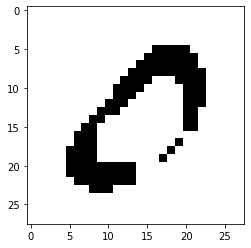

In [40]:
test = np.zeros(10) + 0.01
test[0] = 0.99

picture = nw.query(test)
p = np.array(list(map(lambda x: round(x), np.ravel(picture))))
print('Number = ', np.argmax(test))
display_number(p)